Example of runnning CBM iteratively. CBM is run for several intervals with an opportunity to adjust disturbance events between each interval.  

The script creates a seperate CBM-CFS3 project for each simulation interval and injects the previous simulation state into each subsequent interation.

Each interval's CBM-CFS3 project has varying disturbance levels, in this case the script sets the harvest C target to be 5% of each previous iteration's end-of-interval total biomass C.

In [36]:
import sys, os, json, subprocess
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [37]:
import sit_helper
standard_import_tool_plugin_path=sit_helper.load_standard_import_tool_plugin()
import cbm3_python_helper
cbm3_python_helper.load_cbm3_python()

import cbm3_python.simulation.projectsimulator
from cbm3_python.cbm3data import cbm3_results
from cbm3_python.cbm3data.aidb import AIDB
from cbm3_python.cbm3data.accessdb import AccessDB
from cbm3_python.cbm3data.projectdb import ProjectDB
from cbm3_python.simulation.simulator import Simulator
from cbm3_python.cbm3data import cbm3_results

In [38]:
local_working_dir = os.path.abspath(".")
toolbox_path = r'C:\Program Files (x86)\Operational-Scale CBM-CFS3'
aidb_path=os.path.join(toolbox_path, "admin", "dbs", "ArchiveIndex_Beta_Install.mdb")
cbm_exe_path=os.path.join(toolbox_path, "admin", "executables")
cbm_wd = os.path.join(toolbox_path, "temp")

#the number of steps in each iteration
iteration_steps = 10
#the number of iterations
num_iterations = 5

The following methods inject disturbances and transition rules into the iteration import function.

In [39]:
def create_event_factory(events):
    def factory(config):
        for e in events:
            config.add_event(**e)
    return factory
            
def create_transition_rule_factory(transitions):
    def factory(config):
        for t in transitions:
            config.add_transition_rule(**t)
    return factory

Updates the number of timesteps to run for the given CBM project (AccessDB instance)

In [40]:
def set_project_run_length(proj, n_steps):
    proj.ExecuteQuery("UPDATE tblRunTableDetails SET tblRunTableDetails.RunLength = ?", n_steps)

Path helper functions

In [41]:
def get_project_path(iteration_num):
    return os.path.join(local_working_dir, "iterative_cbm", "iterative_cbm_{}.mdb".format(iteration_num))

def get_results_db_path(iteration_num):
    return os.path.join(local_working_dir, "iterative_cbm", "iterative_cbm_results_{}.mdb".format(iteration_num))

def get_config_save_path(iteration_num):
    return os.path.join(local_working_dir, "iterative_cbm", "iterative_cbm_config_{}.json".format(iteration_num))

def get_iteration_tempfiles_dir(iteration_num):
    return os.path.join(local_working_dir, "iterative_cbm", "iterative_cbm_tempfiles_{}".format(iteration_num))

Sets up and imports a constant SIT inventory with varying events and transition rules at the specified path

In [42]:
def iteration_import(project_path, config_save_path, events_factory, transition_factory):


    c = sit_helper.SITConfig(
        imported_project_path=project_path,
        initialize_mapping=True
    )
    c.data_config(
        age_class_size=5,
        num_age_classes=14,
        classifiers=["admin", "eco", "Leading Species", "Land Cover"])

    c.set_admin_eco_mapping("admin","eco")
    c.set_species_classifier("Leading Species")
    c.map_species("Nonforest", "Not stocked")

    c.add_inventory(classifier_set=["British Columbia", "Boreal Cordillera", "Luvisolic (W. Canada)", "Nonforest"],
                    area=100, age=0, unfccc_land_class=1)
    c.add_inventory(classifier_set=["British Columbia", "Boreal Plains", "Luvisolic (W. Canada)", "Nonforest"],
                    area=100, age=0, unfccc_land_class=1)
    c.add_inventory(classifier_set=["British Columbia", "Taiga Plains", "Luvisolic (W. Canada)", "Nonforest"],
                    area=100, age=0, unfccc_land_class=1)
    c.add_inventory(classifier_set=["British Columbia", "Pacific Maritime", "Luvisolic (W. Canada)", "Nonforest"],
                    area=100, age=0, unfccc_land_class=1)
    c.add_inventory(classifier_set=["British Columbia", "Montane Cordillera", "Luvisolic (W. Canada)", "Nonforest"],
                    area=100, age=0, unfccc_land_class=1)
    
    c.add_inventory(classifier_set=["British Columbia", "Boreal Cordillera", "Spruce", "Forest Only"],
                    area=1000, age=50, unfccc_land_class=0,
                    historic_disturbance="Wildfire", last_pass_disturbance="Wildfire")
    c.add_inventory(classifier_set=["British Columbia", "Boreal Plains", "Spruce", "Forest Only"],
                    area=1000, age=50, unfccc_land_class=0,
                    historic_disturbance="Wildfire", last_pass_disturbance="Wildfire")
    c.add_inventory(classifier_set=["British Columbia", "Taiga Plains", "Spruce", "Forest Only"],
                    area=1000, age=50, unfccc_land_class=0,
                    historic_disturbance="Wildfire", last_pass_disturbance="Wildfire")
    c.add_inventory(classifier_set=["British Columbia", "Pacific Maritime", "Spruce", "Forest Only"],
                    area=1000, age=50, unfccc_land_class=0,
                    historic_disturbance="Wildfire", last_pass_disturbance="Wildfire")
    c.add_inventory(classifier_set=["British Columbia", "Montane Cordillera", "Spruce", "Forest Only"],
                    area=1000, age=50, unfccc_land_class=0,
                    historic_disturbance="Wildfire", last_pass_disturbance="Wildfire")

    growth_curve_data = [0,0,0,27,84,155,217,271,317,353,382,406,426,426]

    not_stocked_growth = [0.0]*len(growth_curve_data)

    c.add_yield(classifier_set=["?","?","?","Nonforest"],
                leading_species_classifier_value="Not stocked",
                values=not_stocked_growth)

    c.add_yield(classifier_set=["?","?","Red pine","Forest Only"], 
                leading_species_classifier_value="Red pine", values=growth_curve_data)
    
    c.add_yield(classifier_set=["?","?","Spruce","Forest Only"], 
                leading_species_classifier_value="Spruce", values=growth_curve_data)
    
    events_factory(c)
    transition_factory(c)
    
    c.import_project(standard_import_tool_plugin_path, config_save_path)

    

Set up the first iteration.  This is a typical CBM run the since the stand initialization routine (Makelist) is run to estimate initial forest conditions.


In [43]:
events = [
    {
    "classifier_set": ["?","?","?","?"],
    "disturbance_type": "Afforestation", 
    "time_step": 1, 
    "target": 100,
    "target_type": "Area",
    "sort": "SORT_BY_SW_AGE"
    }
]
transitions = [
    {
    "classifier_set_source": ["?","?","?","?"],
    "classifier_set_target": ["?","?","Red pine","Forest Only"],
    "disturbance_type": "Afforestation",
    "percent": 100
    }
]

iteration_num = 1
project_path = get_project_path(iteration_num)
tempfiles_dir = get_iteration_tempfiles_dir(iteration_num)
results_db_path = get_results_db_path(iteration_num)

iteration_import(
    project_path,
    get_config_save_path(iteration_num),
    create_event_factory(events),
    create_transition_rule_factory(transitions))

In [44]:
with AIDB(aidb_path, False) as aidb, \
     AccessDB(project_path, False) as proj:

    set_project_run_length(proj, iteration_steps)
    simId = aidb.AddProjectToAIDB(proj)
    s = Simulator(cbm_exe_path,
                simId,
                os.path.dirname(project_path),
                cbm_wd,
                toolbox_path)
    

    s.CleanupRunDirectory()
    s.CreateMakelistFiles()
    s.copyMakelist()
    s.runMakelist()
    s.loadMakelistSVLS()
    s.DumpMakelistSVLs()
    s.CreateCBMFiles()
    s.CopyCBMExecutable()
    s.RunCBM()
    s.CopyTempFiles(output_dir=tempfiles_dir)
    s.LoadCBMResults(output_path = results_db_path)

now run subsequent iterations

In [ ]:

for i in range(2,num_iterations+1):
    iteration_num = i
    project_path = get_project_path(iteration_num)
    tempfiles_dir = get_iteration_tempfiles_dir(iteration_num)
    results_db_path = get_results_db_path(iteration_num)

    #get the total biomass from a previous iteration
    total_biomass = cbm3_results.load_pool_indicators( get_results_db_path(i-1))["Total Biomass"][-1:].values[0]
    #set the target to 5% of the total biomass from the previous iteration
    targetC = total_biomass * 0.05
    
    #create a series of events (divided by the number of iterations)
    events = [
        {
        "classifier_set": ["?","?","?","?"],
        "disturbance_type": "Clear-cut with slash-burn", 
        "time_step": x+1, 
        "target": targetC/iteration_steps,
        "target_type": "Merchantable",
        "sort": "MERCHCSORT_TOTAL"
        } for x in range(iteration_steps)
    ]
    
    #import the project with new disturbance events
    iteration_import(
        project_path,
        get_config_save_path(iteration_num),
        create_event_factory(events),
        create_transition_rule_factory([]))
    
    with AIDB(aidb_path, False) as aidb, \
         AccessDB(project_path, False) as proj:

        proj.ExecuteQuery("UPDATE tblRunTableDetails SET tblRunTableDetails.RunLength = ?", iteration_steps)
        simId = aidb.AddProjectToAIDB(proj)
        s = Simulator(cbm_exe_path,
                    simId,
                    os.path.dirname(project_path),
                    cbm_wd,
                    toolbox_path)

        s.CleanupRunDirectory()
        s.CopyToWorkingDir(project_path)
        s.CreateCBMFiles()
        s.CopyCBMExecutable()
        s.CopySVLFromPreviousRun(os.path.join(get_iteration_tempfiles_dir(i-1),"CBMRun","output"))
        s.RunCBM()
        s.CopyTempFiles(output_dir=tempfiles_dir)
        s.LoadCBMResults(output_path = results_db_path)
   

In theory the stock values for the last timestep of a previous iteration should be equal to the stock values for the 0th timestep of a current iteration. The next cell shows a small discrepency between timesteps 2 and 3.  Considering that this is a very small relative difference, and noting the fact that CBM3 operates with 32 bit precision (which limits us to 6 to 7 digits) I do not think this indicates a larger issue

In [94]:
i2 = cbm3_results.load_pool_indicators( get_results_db_path(2)).iloc[-1] 
i3 = cbm3_results.load_pool_indicators( get_results_db_path(3)).iloc[0]
pd.DataFrame(data={"i2": i2, "i3": i3, "rel_dif": (i2-i3).abs()/((i2+i3)/2)})

,i2,i3,rel_dif
TimeStep,1.000000e+01,0.000000e+00,2.000000e+00
Aboveground Very Fast DOM,4.872035e+04,4.872035e+04,1.002212e-08
Belowground Very Fast DOM,1.040664e+04,1.040664e+04,2.346008e-08
Aboveground Fast DOM,8.772152e+04,8.772152e+04,4.453012e-08
Belowground Fast DOM,1.980821e+04,1.980821e+04,1.232523e-07
Medium DOM,2.006112e+05,2.006112e+05,1.947174e-08
Aboveground Slow DOM,2.019364e+05,2.019364e+05,9.671981e-09
Belowground Slow DOM,6.523250e+05,6.523250e+05,0.000000e+00
Softwood Stem Snag,6.008220e+04,6.008221e+04,5.688820e-08
Softwood Branch Snag,9.901381e+03,9.901382e+03,4.931446e-08


In [67]:
def merge_iteration_results(results, iteration_steps):
    
    out_results = []
    #correct the timestep
    for i, r in enumerate(results):
        #drop the 0th timestep from the 2nd iteration onwards (it's the same as the last value from each previous iteration)
        out = r.loc[r["TimeStep"]!=0].copy() if i!=0 else r.copy()
        out["TimeStep"] = out["TimeStep"] + i*iteration_steps
        out_results.append(out)

    return pd.concat(out_results, axis=0)
    
    

In [71]:
merged_pool_indicators = merge_iteration_results([
    cbm3_results.load_pool_indicators( get_results_db_path(x))
        for x in range(1, num_iterations+1)
], iteration_steps)




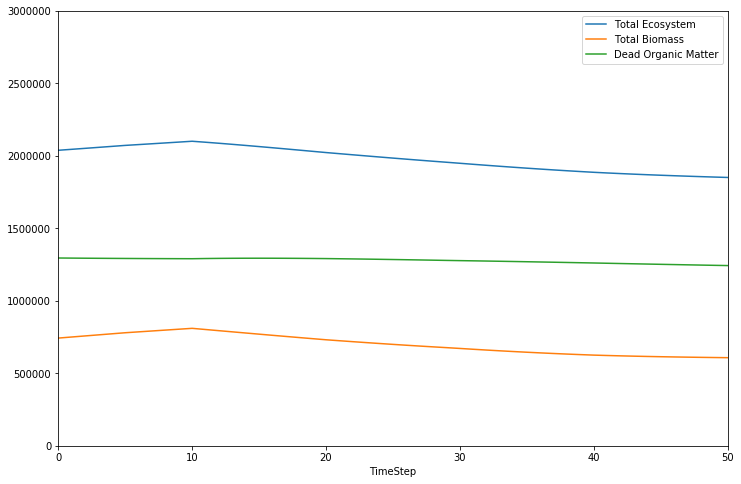

In [90]:
merged_pool_indicators[["TimeStep","Total Ecosystem","Total Biomass","Dead Organic Matter"]] \
    .groupby("TimeStep").sum().plot(ylim=(0,3e6), figsize=(12,8))

In [76]:
merged_stock_changes = merge_iteration_results([
    cbm3_results.load_stock_changes( get_results_db_path(x))
        for x in range(1, num_iterations+1)
], iteration_steps)


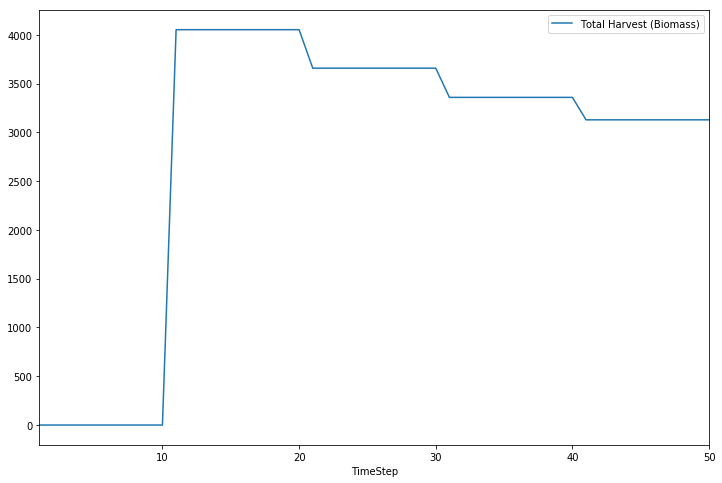

In [91]:
merged_stock_changes[["TimeStep", "Total Harvest (Biomass)"]].groupby("TimeStep").sum().plot(figsize=(12,8))

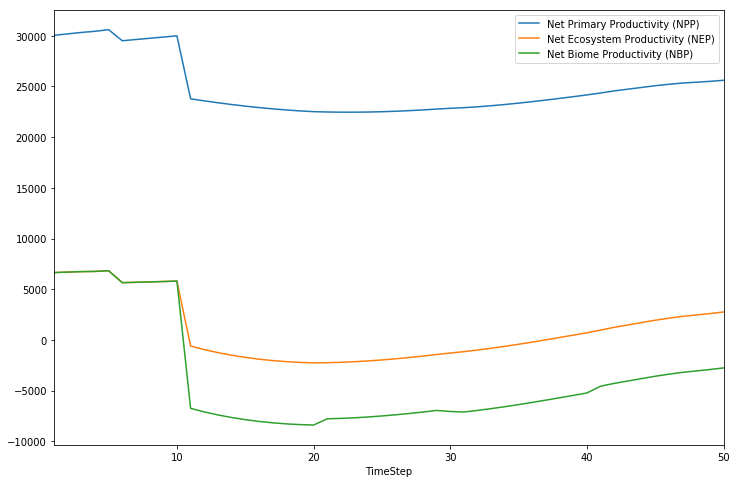

In [92]:
merged_stock_changes[["TimeStep", 'Net Primary Productivity (NPP)',
 'Net Ecosystem Productivity (NEP)',"Net Biome Productivity (NBP)"]].groupby("TimeStep").sum().plot(figsize=(12,8))